In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import datasets, transforms

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#добавим аугментацию к нашим тренировочным данным

In [8]:
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


выведем первые 10 фоток из датасеты с их метками

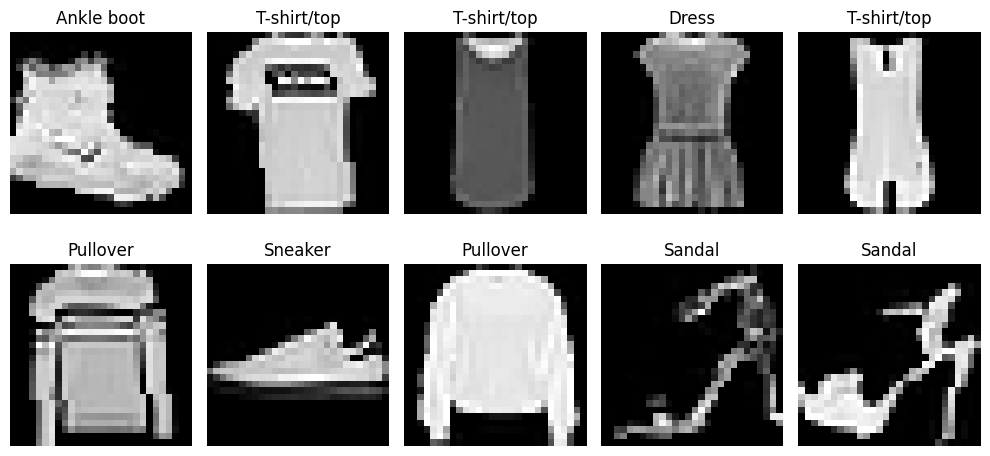

In [20]:
plt.figure(figsize=(10, 5))
for i in range(10):
    image, label = train_data[i]
    
    image = image.squeeze().numpy()
    image = (image * 0.5) + 0.5  
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

разделим датасет на тестовую и обучающую выборку

In [12]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True);
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False);
test_loader = DataLoader(test_dataset, batch_size=64)
#здесь добавил дополнительно тестовый датасет

In [17]:
model_with_cnn = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(64*7*7, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)

In [18]:
summary(model_with_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─ReLU: 1-5                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 128]                  401,536
├─ReLU: 1-9                              [1, 128]                  --
├─Dropout: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0


In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5
no_improve = 0

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss/len(train_loader)
    train_acc = 100*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss/len(val_loader)
    val_acc = 100*correct/total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_cnn_model_augmented.pth')
        print(f'[SAVED] New best model at epoch {epoch+1}')
    else:
        no_improve += 1
    
    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
    
    if no_improve >= patience:
        print(f'\nEarly stopping triggered at epoch {epoch+1}')
        model.load_state_dict(torch.load('best_cnn_model_augmented.pth'))
        break

[SAVED] New best model at epoch 1
Epoch 1/30: Train Loss: 0.3336, Acc: 87.69% | Val Loss: 0.3810, Acc: 86.72%
[SAVED] New best model at epoch 2
Epoch 2/30: Train Loss: 0.3307, Acc: 87.69% | Val Loss: 0.3742, Acc: 86.80%
[SAVED] New best model at epoch 3
Epoch 3/30: Train Loss: 0.3256, Acc: 87.82% | Val Loss: 0.3666, Acc: 86.97%
Epoch 4/30: Train Loss: 0.3261, Acc: 87.90% | Val Loss: 0.3855, Acc: 86.42%
Epoch 5/30: Train Loss: 0.3206, Acc: 88.06% | Val Loss: 0.3865, Acc: 86.46%
Epoch 6/30: Train Loss: 0.3171, Acc: 88.04% | Val Loss: 0.3657, Acc: 87.11%
Epoch 7/30: Train Loss: 0.3138, Acc: 88.36% | Val Loss: 0.3667, Acc: 87.06%
[SAVED] New best model at epoch 8
Epoch 8/30: Train Loss: 0.3108, Acc: 88.36% | Val Loss: 0.3621, Acc: 87.51%
[SAVED] New best model at epoch 9
Epoch 9/30: Train Loss: 0.3094, Acc: 88.42% | Val Loss: 0.3569, Acc: 87.41%
Epoch 10/30: Train Loss: 0.3030, Acc: 88.94% | Val Loss: 0.3667, Acc: 87.48%
Epoch 11/30: Train Loss: 0.3022, Acc: 88.78% | Val Loss: 0.3833, Acc:

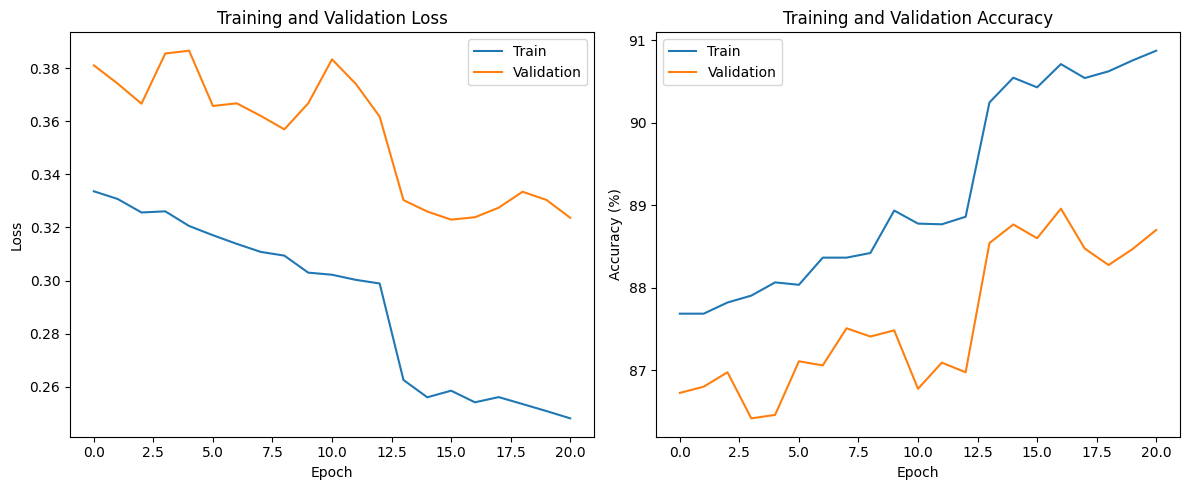

In [22]:
# 7. Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'\nFinal Test Accuracy: {100 * test_correct / test_total:.2f}%')


Final Test Accuracy: 88.06%


можно сделать вывод, что с добавлением аугментации, графики стали менее ровными, но позволили увеличить точность, и сильнее уменьшить значение Loss, а значит что у нее есть свои достоинства и недостатки при обучении